<a href="https://colab.research.google.com/github/marcoslashpro/DQN_Learning/blob/main/MyDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **My first DQN implementation**

We're going to start from [this research paper](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf).

---

The first thing is lay out the components that we are going to need in order to tackle this RL problem, which are(according to the paper):

1.   **The environment $ℰ$**\
      In our case, the environment will be created from the `gymnasium` package, specifically the `CartPole-V1`, as it gives a very simple environment that we can test in order to see if our implmentation works.\
      The **environment** will give us access to the `states`, `actions` and `rewards`.\
      This gives us access to the **MDP**, that we can then use to train our RL algorithm.


2.   **ReplayBuffer** \
      As the agent is trained in the environment, he will come across some **experiences**, which in [this paper](https://apps.dtic.mil/sti/tr/pdf/ADA261434.pdf) are described as a tuple of `(s,a,s_,r,d)`, where:
      
      `s` is the state,
      
      `a` is the action the agent takes given input `s`,
      
      `s_` is the next state in which the agent moves as a consequence of taking action `a` in state `s`,
          
      `r` is the reward(called reinforcement in the paper) for transitioning to the state `s_`,
      
      `d` is a boolean flag representing if an episode is terminated or not.
      
      This experiences might be either rare, or simply too expensive to let happen multiple times(like in the case of a damage experience), therefor we want the model to be able to save this experiences, and randomly re-experience them in order to learn.
      In this case we are assuming an **environment** that does not drastically change over time, because if it would, then the past experiences would be useless if the lessons learnt from them would not apply anymore.

3.   **Model** \
      The main goal of the model $Q$ is going to be to map from state-action pairs from the experience ReplayBuffer to their $Q$-value, which can be computed as:

  $$Q^*(s,a)=E_{s^\prime}[G_t|+γ\max_{a^\prime}Q^*(s^\prime,a^\prime)|s,a]$$

      Taking advantage of the *Bellman Expectation Equation* we can assign to $Q$ the value of the return given at the current time step $G_t$ plus the discounted reward of the next state, action pair $Q(s^\prime, a^\prime)$.

      Notice: That this is an off-policy algorithm, whose main goal is going to be execute the best action in order to maximize the $Q$ value:
      $$
      a=\max_aQ(s,a;θ)
      $$
      $θ$ here refers to the parameters of the model, which we can modify during training in order to improve the prediction of the action $a$.

      We'll also train a second NN $Q_{target}$, which will compute the value of the optimal next action to take at the future state $s^\prime$ that we'll use to compare the output of agent in order to calculate the loss.
      The oarameters of this model will not be updated at every step of training, but instead they will be updated at every $C$ steps.
      By doing this, the agent will have a clear goal to follow, preventing the agent's parameters to diverge by following an unstable goal.
      At every $C$ steps tho, the parameters of this target model will be updated to the parameters of the agent.

      The loss function used to evaluate the algorithm will be the mean squared error(MSE) and the gradient will be calculated and applied by optimizer Adam.

4. **Exploration** \
      To make the model less prone to get stuck in local minima, and not taking the best actions, we'll introduce a parameter $\epsilon$, that will be used to force the agent to take a random action, in order to explore diferrent state-actions pairs, preventing the model from getting stuck.
    

There are a couple of concepts that we have not talked about, but we'll see them during the implementation, the algorithm we'll implement is given by this algorithm on the 2015 DQN paper linked [here](https://sci-hub.se/10.1038/nature14236), which is:


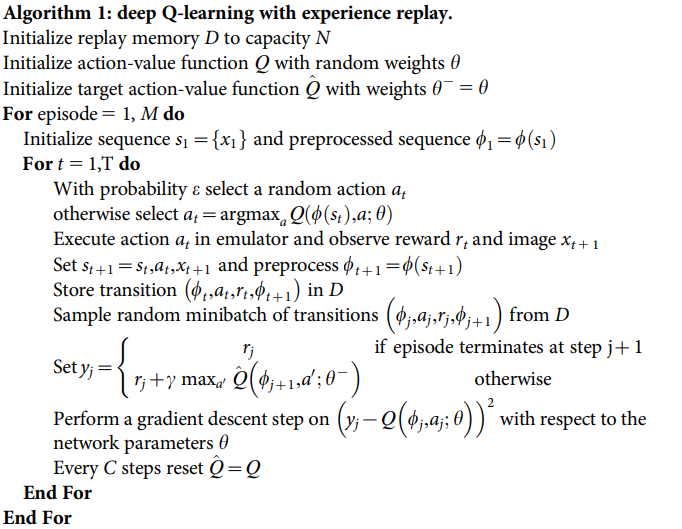

Let's start building our blocks, one by one.

# **imports**

In [ ]:
!pip install -U -q gymnasium

In [ ]:
import gymnasium as gym
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random

# **Models**

## **ReplayBuffer**

The first thing that we are going to lay out is going to be the ReplayBuffer, this will hold all of the information with which we'll train our agent.
On initilization we'll input:
1.  The memory size, that sets the size of our memmory buffer;
2.  The state shape, which will allow us to input as many possible state as the environment gives us.
3. action type, just to make this more versatile, so we could maybe reuse it with a different environment.

Every time that the agent updates his state in the environment, we'll update the memory buffer with a new experience, which is given by this tuple: `(s,a,s_,r,d)`:

In [ ]:
class ReplayBuffer():
  def __init__(self, max_capacity: int, state_shape: tuple, action_dtype: np.dtype) -> None:
    """
    We create a different array for every information that will be in the tuple (s,a,s_,r,d),
    This seems to be best practice and also very fast indexing with the parallel computational power of numpy
    """
    self.max_capacity: int = max_capacity
    self.state_memory: np.ndarray = np.empty((self.max_capacity, *state_shape), dtype=np.float32)
    self.action_memory: np.ndarray = np.empty((self.max_capacity), dtype=action_dtype)
    self.new_state_memory: np.ndarray = np.empty((self.max_capacity, *state_shape), dtype=np.float32)
    self.reward_memory: np.ndarray = np.empty((self.max_capacity), np.int32)
    self.done_memory: np.ndarray = np.empty((self.max_capacity), np.float32)

    #We need the memory index in order to treat the vector store as a queue
    self.memory_idx: int = 0
    #We keep track of the actual size of the memory store
    self.memory_size: int = 0


  def store_experience(self, s: np.ndarray, a: np.ndarray, s_: np.ndarray, r: int, d: bool) -> None:
    """
    We take in the (s,a,s_,r,d) tuple and allocate every piece of info in the right place
    """
    self.state_memory[self.memory_idx] = s
    self.action_memory[self.memory_idx] = a
    self.new_state_memory[self.memory_idx] = s_
    self.reward_memory[self.memory_idx] = r
    self.done_memory[self.memory_idx] = float(d)

    #This is a neat trick that rounds the idx in which we put the element to 0\
    #when we reach the maximum size of the memory store
    self.memory_idx = (self.memory_idx + 1) % self.max_capacity
    #We keep track of the actual numbers in the array, until it reaches a maximum capacity
    #We need this count or else we would sample empty batches when we try to sample experiences
    self.memory_size = min(self.memory_size + 1, self.max_capacity)


  def sample_experience(self, batch_size: int) -> tuple:
    """
    We return as many elements from any array as the batch_size
    """
    #We check if we have enough elements in memory to ouput a full batch size
    if self.memory_size >= batch_size:
      sampled_idx: np.ndarray = np.random.choice(self.memory_size, batch_size, replace=False)

      return (
          self.state_memory[sampled_idx],
          self.action_memory[sampled_idx],
          self.new_state_memory[sampled_idx],
          self.reward_memory[sampled_idx],
          self.done_memory[sampled_idx],
        )

## **DQNs**

Once the ReplayBuffer has been created, we can now move onto building the deep neural networks that we'll be using, remember that we need two different NN:

1.  $Q$: For the action prediction process;
2.  $Q_{target}$: That we can use in order to evaluate the quality of our actions.

This components allow us to use the **bootstrapping** properties that Bellman equation brings us.
**Bootstrapping** is a very handsome way of saying that we use a future estimate (the one given to us from the $Q_{target}$) in order to quantify and adjust the value of our current estimate $Q$.


The main difference between the two is that the $Q_{target}$ network will not update his parameters, but instead, every $C$ number of steps will copy the ones from the $Q$ network.
The architecture of the two **must** be the same, with the only difference being the absence of the optimizer in $Q_{target}$ network, since we will not update his parameters.
In order to make the process of creating them easier we'll implement an helper function for the creation of the model, and also for the copy of the parameters.

In [ ]:
def build_DQN(input_dims: tuple, inner_units: list[int], n_actions: int, is_target: bool = False, learning_rate=0.01) -> keras.models.Sequential:
  """
  Helper function to build the DQNs.
  Args:
    input_dims: (shape): Must be the same size as the state_space given to the ReplayBuffer model.
    inner_units: list[int]: We use every integer to create a different layer, must be a list even if one layer is wanted.
    n_actions: (int): It is used to assure that the n of units in the last layer is the same as possible actions that the model can take.
    is_target: (bool): Defaults to False, set to true if the model is Qtarget.

  To properly use this function: Use the input_dims for the first layer,
  a list of units with every n in the list mapping to a different inner layer,
  n_actions to properly create the last layer.
  """
  #Create a boilerplate model
  model = keras.models.Sequential()
  model.add(keras.layers.Input(input_dims))

  #Loops for evevry n. of units in the units list, each single value will be a layer
  for u in inner_units:
    model.add(keras.layers.Dense(u, activation='relu'))
  model.add(keras.layers.Dense(n_actions)) #the last layer has a linear activation function

  if is_target:
    return model

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
  return model

# **Agent**

Now that we have laied out all of our pieces, it's tie them up together.
To do this, we'll implement an `Agent` class that will be in charge of:

1.  Building the networks on init;
2.  Select an action;
3.  Observer the reward;
4.  Transition to the next state;
5.  Save the experience in the ReplayBuffer;
6.  Sample a batch from the ReplayBuffer;
7.  Execute gradient descent on model $Q$;
8.  Every $C$ step update the $Q_{target}$ parameters, with respect to $Q$.

In [ ]:
class Agent():
  def __init__(
        self,
        memory: ReplayBuffer,
        Q: keras.models.Sequential,
        Qtarget: keras.models.Sequential,
        epsilon: float,
        gamma: float,
        batch_size: int,
        n_actions: int,
        epsilon_decay: float,
        target_update_freq: int
      ) -> None:
    self.action_space = list(range(n_actions))
    self.memory = memory
    self.Q = Q
    self.Qtarget = Qtarget
    self.epsilon = epsilon
    self.gamma = gamma
    self.batch_size = batch_size
    self.eps_dec = epsilon_decay
    self.target_update_freq = target_update_freq

    #this is used to update the Qtarget weights
    self.learning_step_counter = 0

    #On init we sync the Q and Qtarget's weights
    self.update_target_network_weights()

  def update_target_network_weights(self) -> None:
    """
    Helper function to copy the weights from model Q to Qtarget.
    """
    self.Qtarget.set_weights(self.Q.get_weights())

  def select_action(self, state: np.ndarray) -> np.ndarray:
    """
    After we're given the current state we can take an action, according to the
    epsilon greedy policy.
    """
    #Select random action according to epsilon
    if random.random() < self.epsilon:
      action = np.random.choice(self.action_space)
      return int(action)

    #Else select best action
    #we want to re-arrange the array in a way that keras can process it.
    #it is of shape (8, ), but only 2-D are accepted, therefor we modify to be (1,8)
    state_batch = state[np.newaxis, :]

    #the Q model here predicts the action to take, from the re-arranged states
    actions = self.Q.predict(state_batch, verbose=0)

    #we select the best action.
    action = np.argmax(actions)

    #update epsilon value
    self.epsilon = self.epsilon - self.eps_dec if self.epsilon > 0.1 else self.epsilon

    return action

  def train_step(self) -> None:
    """
    Here we train the Q model on the Qtarget prediction.
    Every set amount of steps we update the Qtarget parameters
    """
    #If the memory size is not at least as big as the batch size we can't train yet
    if self.memory.memory_size < self.batch_size:
      return

    #Sample experiences from the buffer
    s, a, s_, r, d = self.memory.sample_experience(self.batch_size)

    #the Qtarget model predict the future best action
    as_ = self.Qtarget.predict(s_, verbose=0)
    max_next_q_values = np.max(as_, axis=1)
    target_q_values = r + self.gamma * max_next_q_values * (1-d) #(1-d) Zeros out the reward of the terminal state

    # --- Prepare training data for the MAIN network ---
    # Keras train_on_batch expects the target to have the same shape as the network output (batch_size, n_actions)
    # We have calculated the target_q_values (batch_size,) ONLY for the action that was taken.
    # We need to create a target tensor that is mostly the main network's *current* prediction,
    # but with the target_q_value ONLY for the action that was taken in that state.

    # Get the main network's current predictions for the batch of states
    y_hat = self.Q.predict(s, verbose=0)

    action_indices = tf.stack([tf.range(self.batch_size), tf.cast(a, tf.int32)], axis=1)
    target_y = tf.tensor_scatter_nd_update(y_hat, action_indices, target_q_values)

    #train the Q model
    self.Q.train_on_batch(s, target_y)

    self.learning_step_counter += 1

    # Call the update_target_network_weights method based on the counter
    if self.learning_step_counter % self.target_update_freq == 0:
        self.update_target_network_weights()

  def store_experience(self, s: np.ndarray, a: int, s_: np.ndarray, r: float, d: bool) -> None:
    """
    We store the experience in the ReplayBuffer
    """
    self.memory.store_experience(s,a,s_,r,d)

# **Main**

Now that we have our agent, it's time to run traininig(with respect to the algorithm that we saw before) and see what happens.

In [ ]:
env = gym.make('CartPole-v1')
agent = Agent(
    memory=ReplayBuffer(
        100000,
        env.observation_space.shape,
        action_dtype=env.action_space.dtype
    ),
    Q=build_DQN(
        input_dims=env.observation_space.shape,
        inner_units=[206,128],
        n_actions=env.action_space.n,
        learning_rate=0.0001
    ),
    Qtarget=build_DQN(
        input_dims=env.observation_space.shape,
        inner_units=[206,128],
        n_actions=env.action_space.n,
        is_target=True,
        learning_rate=0.0001
    ),
    epsilon=0.99,
    gamma=0.2,
    batch_size=128,
    n_actions=env.action_space.n,
    epsilon_decay=0.05,
    target_update_freq=1000
)

In [ ]:
episodes = 20

scores = []

for episode in range(episodes):
  score = 0
  observation = env.reset()[0]
  while True:
    action = agent.select_action(observation)
    updated_epsilon = agent.epsilon
    observation_, reward, terminated, truncated, info = env.step(action)
    score += reward
    agent.store_experience(observation[0], action, observation_, reward, terminated)
    agent.train_step()
    observation = observation_
    if terminated:
      break
  scores.append(score)
  print(f'Episode: {episode+1}, score: {score}')

Episode: 1, score: 28.0
Episode: 2, score: 25.0
Episode: 3, score: 24.0
Episode: 4, score: 31.0
Episode: 5, score: 30.0
Episode: 6, score: 25.0
Episode: 7, score: 30.0
Episode: 8, score: 18.0
Episode: 9, score: 10.0
Episode: 10, score: 25.0
Episode: 11, score: 27.0
Episode: 12, score: 21.0
Episode: 13, score: 12.0
Episode: 14, score: 11.0
Episode: 15, score: 19.0
Episode: 16, score: 26.0
Episode: 17, score: 24.0
Episode: 18, score: 23.0
Episode: 19, score: 12.0
